<a href="https://colab.research.google.com/github/artms-18/ML-Projects/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## STOCK PREDICTION WITH TENSORFLOW 2.0!

In this notebook, we will be predicting prices of General Electric's stock using a Transformer neural network

## Step 1 - Import data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

In [ ]:
uploaded = files.upload()


Saving GE.csv to GE.csv


In [ ]:
for fn in uploaded.keys():
  print("User uploaded file {name} with length {length} bytes".format(name = fn, length = len(uploaded[fn])))

User uploaded file GE.csv with length 17046 bytes


In [ ]:
import io

df = pd.read_csv(io.StringIO(uploaded['GE.csv'].decode('utf-8')))

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-04,6.30,6.31,6.15,6.21,6.180224,136852400
1,2020-05-05,6.28,6.46,6.16,6.20,6.170272,116998500
2,2020-05-06,6.20,6.25,5.97,5.98,5.951327,117253600
3,2020-05-07,6.06,6.26,6.06,6.11,6.080704,100663300
4,2020-05-08,6.21,6.33,6.16,6.29,6.259841,93637300


In [ ]:
# Sort Dataframe by date

df = df.sort_values('Date')

# Check result

df.head()



,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-04,6.30,6.31,6.15,6.21,6.180224,136852400
1,2020-05-05,6.28,6.46,6.16,6.20,6.170272,116998500
2,2020-05-06,6.20,6.25,5.97,5.98,5.951327,117253600
3,2020-05-07,6.06,6.26,6.06,6.11,6.080704,100663300
4,2020-05-08,6.21,6.33,6.16,6.29,6.259841,93637300


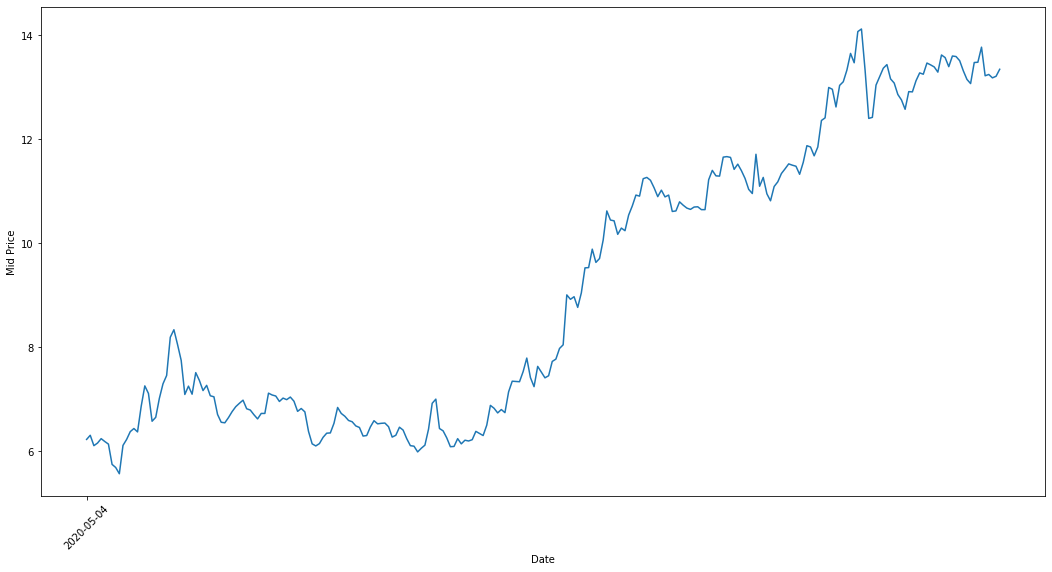

In [ ]:
# Visualize data

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]), (df['Low'] + df['High'])/2.0)
plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[::500], rotation = 45)
plt.xlabel('Date', fontsize = 10)
plt.ylabel('Mid Price', fontsize = 10)
plt.show()

## Step 2 - Data preprocessing

In [ ]:
df['mid'] = (df['Low'] + df['High'])/2.0

In [ ]:
SEQ_LEN = 60 # how long of a preceeding sequence to collect for RNN

FUTURE_PERIOD_PREDICT = 1 # how far in the future are we trying to predict?

RATIO_TO_PREDICT = 'mid'

In [ ]:
def classify(current, future):
  if float(future) > float(current):
    return 1
  else:
    return 0

In [ ]:
df['future'] = df[RATIO_TO_PREDICT].shift(-FUTURE_PERIOD_PREDICT) #shifts by 1

In [ ]:
df['target'] = list(map(classify, df[RATIO_TO_PREDICT], df['future']))

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,mid,future,target
0,2020-05-04,6.30,6.31,6.15,6.21,6.180224,136852400,6.230,6.310,1
1,2020-05-05,6.28,6.46,6.16,6.20,6.170272,116998500,6.310,6.110,0
2,2020-05-06,6.20,6.25,5.97,5.98,5.951327,117253600,6.110,6.160,1
3,2020-05-07,6.06,6.26,6.06,6.11,6.080704,100663300,6.160,6.245,1
4,2020-05-08,6.21,6.33,6.16,6.29,6.259841,93637300,6.245,6.190,0


In [ ]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,mid,future,target
247,2021-04-27,13.50,13.54,12.91,13.49,13.49,149775000,13.225,13.250,1
248,2021-04-28,13.33,13.35,13.15,13.20,13.20,66095400,13.250,13.185,0
249,2021-04-29,13.18,13.29,13.08,13.21,13.21,55157600,13.185,13.215,1
250,2021-04-30,13.16,13.35,13.08,13.12,13.12,49863500,13.215,13.350,1
251,2021-05-03,13.24,13.53,13.17,13.45,13.45,63472485,13.350,NaN,0


In [ ]:
times = sorted(df.index.values) # get the times

last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # get the last 10% of the times
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # get the last 20% of the times

test_df = df[(df.index >= last_10pct)]
validation_df = df[(df.index >= last_20pct) & (df.index < last_10pct)]
train_df = df[(df.index < last_20pct)] # now the train_df is all the data up to the last 20%

In [ ]:
from collections import deque
import numpy as np
import random

In [ ]:
train_df.drop(columns = ['Date', 'future', 'Open', 'High', 'Low', 'Close', 'Volume'], inplace = True)
validation_df.drop(columns = ['Date', 'future', 'Open', 'High', 'Low', 'Close', 'Volume'], inplace = True)
test_df.drop(columns = ['Date', 'future', 'Open', 'High', 'Low', 'Close','Volume'], inplace = True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train_df.head()

,Adj Close,mid,target
0,6.180224,6.230,1
1,6.170272,6.310,0
2,5.951327,6.110,1
3,6.080704,6.160,1
4,6.259841,6.245,0


In [ ]:
# putting data into an array format

train_data = train_df[RATIO_TO_PREDICT].to_numpy()
valid_data = validation_df[RATIO_TO_PREDICT].to_numpy()
test_data  = test_df[RATIO_TO_PREDICT].to_numpy()

array([12.915, 13.13 , 13.28 , 13.255, 13.47 , 13.435, 13.395, 13.295,
       13.625, 13.575, 13.4  , 13.605, 13.595, 13.515, 13.32 , 13.155,
       13.075, 13.48 , 13.485, 13.775, 13.225, 13.25 , 13.185, 13.215,
       13.35 ])

In [ ]:
# reshaping data

train_data = train_data.reshape(-1,1) # flattens data along y axis
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
# Train the scaler with training data and smooth data

smoothing_window_size = 2500

for di in range(0, 10000, smoothing_window_size):
  scaler.fit(train_data[di: di + smoothing_window_size,:])
  train_data[di: di+smoothing_window_size:,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# Normalize the last bit of remaining data

scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di + smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

ValueError: ignored